## Mammogram classification

For the exercise sessions on medical image classification, we will be exploring mammogram classification.

The goals are:

* To explore data from different mammography datasets
* To apply a model pretrained on dataset 1 to datasets 2 and 3
* Investigate how the results from a published paper differ across domains

Credits: thanks to Frederik Bechmann Faarup, Amelia Jímenez-Sánchez and Sebestyen Nagy for sharing ideas and creating or updating the code included in this notebook. 



In [ ]:
# Clone the repository with example images and code

if True:      #A weird trick needed for Google Colab
  !rm -rf breast_cancer_classifier
  !git clone https://github.com/vcheplygina/breast_cancer_classifier.git 

Cloning into 'breast_cancer_classifier'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 150 (delta 1), reused 1 (delta 0), pack-reused 145
Receiving objects: 100% (150/150), 227.72 MiB | 32.04 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Checking out files: 100% (68/68), done.


Each patient in the sample data is represented 2 CC view mammography images of size 2677x1942 and 2 MLO view mammography images of size 2974x1748.

In [ ]:
import pandas as pd, numpy as np
import os, shutil
from glob import glob
from tqdm import tqdm
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from colorama import Fore, Back, Style
from mpl_toolkits.axes_grid1 import ImageGrid
import random
import imagesize
import subprocess
sns.set(style='dark')

In [ ]:
# Some starting support functions (credit Frederik Bechmann Faarup) 

def get_list_images(base):
    directory = os.fsencode(base)
    list_of_images = []
    for file in os.listdir(directory):
        if not file.endswith(b".png"):
            continue
        filename = os.fsdecode(file)
        list_of_images.append(base + "/" + filename)
    return list_of_images

def show_img(path):
    img = cv2.imread(path,0)
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    plt.title(path)


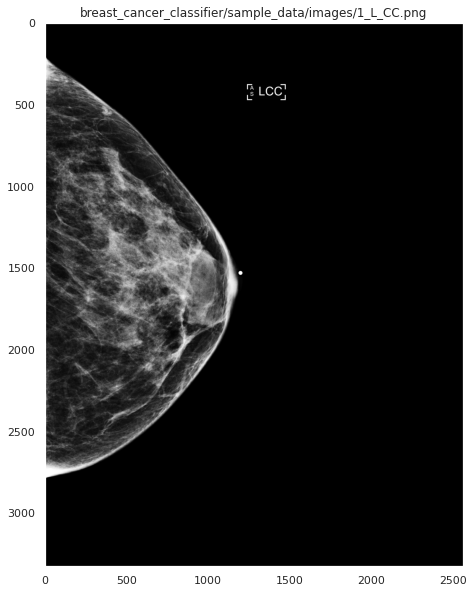

In [ ]:
# Display some images to understand the relationship between different scans for the same patient

sample_list = get_list_images('breast_cancer_classifier/sample_data/images')
show_img(sample_list[0])


In [ ]:

# TODO FOR STUDENTS 
# You may want to implement a support function to show you all single for a single patient in one go


## Reproduce the sample result

We can choose to classify either an entire exam (based on the four views), or just a single view. 

We will work with the exam-level, image-only model here: https://github.com/nyukat/breast_cancer_classifier

The run.sh script (https://github.com/nyukat/breast_cancer_classifier/blob/master/run.sh) contains the steps (including preprocessing) to do this.

Since we are using the image-only model (no heatmaps), you only need to complete steps 1, 2 and 4a. 


In [ ]:
# TODO FOR STUDENTS - Reproduce the sample result in repo

 

## Get the INBreast dataset

Next we apply this model to another dataset. The INBreast dataset, documented here https://pubmed.ncbi.nlm.nih.gov/22078258/, has 115 full-field digital mammography exams in total. Of these, 90 exams have four views.

Download the data here: https://www.kaggle.com/datasets/martholi/inbreast?resource=download and unzip it. 

The images are in a DICOM format (https://en.wikipedia.org/wiki/DICOM) which is frequently use in medicine. The files are relatively large compared to PNG images, so you likely will not be able to add them directly to a Github repository.

Let's explore a file first. 


In [ ]:
!pip install pydicom
import pydicom



In [ ]:

#Load a file - you will need to update the file location
dcm = pydicom.read_file('enter_filepath_here.dcm')

#You can explore the different properties (some of which are themselves data structures) the DICOM has, for example
name = dcm.PatientName
date = dcm.StudyDate
bits_stored = dcm.BitsStored

# TODO FOR STUDENTS: 
# What can you say about the meta-data in the DICOMs? Compare it to the meta-data provided in the INBREAST.xls meta-data file 





In [ ]:
# To get the actual image, we use the function pixel_array and display it:

image = dcm.pixel_array
plt.imshow(image, cmap='gray')

# TODO FOR STUDENTS:
# What do you notice visually about these images, compared to the sample data? Can you verify this intuition?

## Convert data to PNGs

To use this data with the trained models, we should convert the DICOMs to the same format as the training data. You may use the support functions below (you will need to modify the file paths). 

In [ ]:
# Convert DICOMs to PNG, support functions by Frederik Bechmann Faarup
import png
def save_dicom_image_as_png(dicom_filename, png_filename, bitdepth=12):
    """
    Save 12-bit mammogram from dicom as rescaled 16-bit png file.
    :param dicom_filename: path to input dicom file.
    :param png_filename: path to output png file.
    :param bitdepth: bit depth of the input image. Set it to 12 for 12-bit mammograms.
    """
    image = pydicom.read_file(dicom_filename).pixel_array
    with open(png_filename, 'wb') as f:
        writer = png.Writer(height=image.shape[0], width=image.shape[1], bitdepth=bitdepth, greyscale=True)
        writer.write(f, image.tolist())

def all_inbreast_to_png(meta_df, base_path):
    dicom_base = base_path + "/AllDICOMs"
    #the shell commands just create the directory structure assumed by the function
    #you can also create them manually
    if "AllDICOMs" not in os.listdir(base_path):
        #create folder
        subprocess.run(["mkdir", "-p", dicom_base])
        #move all .dcm files to folder
        subprocess.run(["mv", f"{base_path}/*.dcm", dicom_base])
        
    png_base = base_path + "/png_versions"
    if "png_versions" not in os.listdir(base_path):
        subprocess.run(["mkdir", "-p", png_base])
    
    directory = os.fsencode(dicom_base)
    for file in os.listdir(directory):
        dicom_filename = os.fsdecode(file)
        if not dicom_filename.endswith(".dcm"): # Check only for dcm files
            continue
        png_filename = os.fsdecode(file).replace(".dcm", ".png")

        full_dicom_path = dicom_base + "/" + dicom_filename
        full_png_path = png_base + "/" + png_filename

        save_dicom_image_as_png(full_dicom_path, full_png_path)

        flnm = int(dicom_filename.split("_")[0])
        meta_df.loc[meta_df["File Name"] == flnm, "png_path"] = full_png_path
        meta_df.loc[meta_df["File Name"] == flnm, "png_filename"] = png_filename
        meta_df.loc[meta_df["File Name"] == flnm, "png_base"] = png_base

    return meta_df

In [ ]:
# Convert all images and store the new file paths
base_path = 'ALL-IMGS'
meta_df = pd.read_excel("INbreast.xls")
meta_df["png_path"] = 0
meta_df["png_filename"] = 0
meta_df["png_base"] = 0
meta_df = meta_df.dropna(axis=0, subset=["File Name"])

#this is gonna take a while, so you can go grab some coffee
meta_df = all_inbreast_to_png(meta_df, base_path)

#you can use this dataframe to iterate through all images
#but it's recommended to create a metadata file
#similar to sample_data/exam_list_before_cropping.pkl
meta_df.to_csv("INbreast_with_img_loc.csv", index=False)

## Explore data distributions

Examine the intensity distributions of the image pixels. You can use the kdeplot function in seaborn to plot the distributions (see https://seaborn.pydata.org/generated/seaborn.kdeplot.html ) 



In [ ]:
# TODO FOR STUDENTS: Plot intensity distributions, compare sample data to INBreast


You can also compare the exams within INBreast based on the meta-data found in INBreast.xls . Here the ACR column stores the breast density and the Bi-Rads column stores the diagnostic assessment (https://en.wikipedia.org/wiki/BI-RADS).  

In [ ]:

# TODO FOR STUDENTS: Plot intensity distributions, compare different exams within INBreast. How do these properties visually affect the exam?

## Evaluate model on INBreast

Having explored the data distributions, what are your predictions about applying the trained model to the INBreast data? 

To be able to calculate performance measures, you will need to convert the Bi-Rads scores to "benign" and "malignant" labels. You may do this following the method from the Wu et al paper:

* Malignant if BI-RADS 4, 5 or 6
* Benign if BI-RADS 1 or 2
* Discarded if BI-RADS 3, because the assessment is typically not given at screening

With binary benign/malignant labels, you can then evaluate AUC for the output provided by the model. 

In [ ]:
# TODO FOR STUDENTS: Evaluate trained model on the INBreast data. 

# Look at Table III in the Wu et al paper (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8861376) 
# Is your AUC, for the same type of model, similar to what they report (note they use a different, private dataset)?



## Option A - Explore DDSM 

You can repeat the steps above for another dataset, DDSM. You can find more details about the data here: https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM. 

Although these are also DICOM images, you will find some differences to how the data is saved/reported. 

The dataset is much larger than INBreast, please check if you have enough space on your disk where you want to save it. You may also use just a part of the dataset for computational reasons. 

In [ ]:
## TODO FOR STUDENTS: Make an overview/summary table, showing what types of attributes/meta-data differ across datasets

In [ ]:
## TODO FOR STUDENTS: Compare data distributions, across datasets, and across groups within the dataset

## Option B - Domain adaptation

This is a bit more of an open ended assignment. You can try to modify the data and/or the model, to improve the results on INBreast. 

You could for example try to 
* normalize the histograms, to align the data distributions better
* create an ensemble of different models
* fine-tune a trained network